In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.read_csv('NFL_pbp_2009-2019.csv', low_memory=False)

threshold = 100000
df['field_goal_result'].fillna('none', inplace=True)
dfV2 = df.loc[:, df.isnull().sum() < threshold]
missing_values = dfV2.isnull().sum()

statistical_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 
                    'defteam', 'side_of_field', 'yardline_100', 'half_seconds_remaining', 
                    'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down', 'goal_to_go', 'time', 
                    'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'home_timeouts_remaining', 
                    'away_timeouts_remaining', 'total_home_score',  'total_away_score', 'score_differential', 'home_wp', 'away_wp', 'ep']

game_dynamics_cols = [
    'punt_blocked', 'first_down_rush', 'first_down_pass', 'first_down_penalty', 'third_down_converted',
    'third_down_failed', 'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass', 'interception',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty',
    'tackled_for_loss', 'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit',
    'rush_attempt', 'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'field_goal_result',
    'return_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt',
    'punt_attempt', 'fumble', 'complete_pass', 'shotgun', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty']

columns_to_keep = statistical_cols + game_dynamics_cols
dfV3 = dfV2[columns_to_keep]

dfV4 = dfV3.drop(['play_id', 'game_seconds_remaining', 'fumble_forced'], axis=1)
dfV4 = dfV4.dropna(subset=['down', 'defteam', 'posteam'])
dfV4 = dfV4.reset_index(drop=True)

# Indicators for if within last 2 minutes of the half and the whole game
dfV4['close_to_end_of_half'] = (dfV4['half_seconds_remaining'] <= 120).astype(int)
dfV4['close_to_end_of_game'] = ((dfV4['half_seconds_remaining'] <= 120) & (dfV4['game_half'] == 'Half2')).astype(int)

# Indicator for if the touchdown was for the away or home team
dfV4['home_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['away_team'])).astype(int)
dfV4['away_td'] = ((dfV4['touchdown'] == 1) & (dfV4['posteam'] != dfV4['home_team'])).astype(int)

# Trackers for the difference in both teams' win probability after each play
dfV4['home_wp_change'] = dfV4['home_wp'].diff().fillna(0)
dfV4['away_wp_change'] = dfV4['away_wp'].diff().fillna(0)

# Indicator for turnover
dfV4['turnover'] = (
    (dfV4['safety'] == 1) |
    (dfV4['interception'] == 1) |
    (dfV4['fumble_lost'] == 1) |
    ((dfV4['fourth_down_converted'] == 0) & (dfV4['down'] == 4))
).astype(int)

# Drive time - Added drive ended indicator to help - Manually resets after end of game, half, and change of possession
dfV4['drive_ended'] = (
    (dfV4['posteam'] != dfV4['posteam'].shift(1)) |  
    (dfV4['game_id'] != dfV4['game_id'].shift(1)) |  
    dfV4['desc'].str.contains('END GAME', na=False) |  
    dfV4['desc'].str.contains('END QUARTER', na=False)  
).astype(int)
dfV4['drive'] = (
    (dfV4['posteam'].ne(dfV4['posteam'].shift())) |
    (dfV4['game_id'].ne(dfV4['game_id'].shift()))
).cumsum()
dfV4['drive_time_seconds'] = (
    dfV4.groupby(['game_id', 'drive'])['half_seconds_remaining']
    .transform('first') - dfV4['half_seconds_remaining']
)
dfV4['drive_time_seconds'] = dfV4.apply(
    lambda row: 0 if row['drive_ended'] == 1 else row['drive_time_seconds'], axis=1
)
dfV4['drive_time_seconds'] = dfV4.groupby(['game_id', 'drive'])['drive_time_seconds'].cumsum()

# Indicator for long touchdowns
dfV4['long_td'] = ((dfV4['touchdown'] == 1) & (dfV4['yards_gained'] >= 50)).astype(int)

# Trackers for score differentials and lead changes
dfV4['home_score_differential'] = dfV4['total_home_score'] - dfV4['total_away_score']
dfV4['away_score_differential'] = -dfV4['home_score_differential']
dfV4['lead_change'] = ((dfV4['home_score_differential'].diff() < 0) &
                       (dfV4['home_score_differential'].shift() * dfV4['home_score_differential'] < 0)).astype(int)

# Combining first down indicators
dfV4['first_down'] = ((dfV4['first_down_pass'] == 1) | (dfV4['first_down_rush'] == 1) | (dfV4['first_down_penalty'] == 1)).astype(int)

# Indicators for scoring drives - Removing
dfV4['home_scoring_drive'] = (
    (dfV4['home_td'] == 1) 
).astype(int)
dfV4['away_scoring_drive'] = (
    (dfV4['away_td'] == 1) 
).astype(int)

# Helper for consecutive scoring events - Remove Later!!!!!!!!!!!!!!
dfV4['home_scoring_events'] = (
    (dfV4['posteam'] != dfV4['away_team']) & 
    ((dfV4['home_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)
dfV4['away_scoring_events'] = (
    (dfV4['posteam'] != dfV4['home_team']) & 
    ((dfV4['away_td'] == 1) | (dfV4['field_goal_result'] == 'made'))
).astype(int)

# Consecutive Scoring Events + Helper function 
def calc_consecutive_cumsum_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0 
        if reset_series[i] == 1:  
            cumsum = 0
        if series[i] == 1:  
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['home_scoring_events'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_scores'] = calc_consecutive_cumsum_with_game_reset(
    dfV4['away_scoring_events'], dfV4['home_scoring_events'], dfV4['game_id']
)

#Consecutive defensive stops
dfV4['home_def_stop'] = (
    (dfV4['posteam'] != dfV4['home_team']) &  ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])  
).astype(int)
dfV4['away_def_stop'] = (
    (dfV4['posteam'] != dfV4['away_team']) & ((dfV4['punt_attempt'] == 1) |  (dfV4['turnover'] == 1)) & 
    ~dfV4['field_goal_result'].isin(['made'])
).astype(int)

def calc_consecutive_defensive_stops_with_game_reset(series, reset_series, game_ids):
    cumsum = 0
    consecutive = []
    prev_game_id = None  
    for i in range(len(series)):
        if game_ids[i] != prev_game_id:
            cumsum = 0
        if reset_series[i] == 1:
            cumsum = 0
        if series[i] == 1:
            cumsum += 1
        consecutive.append(cumsum)
        prev_game_id = game_ids[i]  
    return consecutive

dfV4['home_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['home_def_stop'], dfV4['away_scoring_events'], dfV4['game_id']
)
dfV4['away_csum_def_stops'] = calc_consecutive_defensive_stops_with_game_reset(
    dfV4['away_def_stop'], dfV4['home_scoring_events'], dfV4['game_id']
)

# Home/Away Drive Numbers
dfV4['away_drive_number'] = (
    dfV4.loc[dfV4['posteam'] != dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)
dfV4['home_drive_number'] = (
    dfV4.loc[dfV4['posteam'] == dfV4['home_team']]
    .groupby('game_id')['drive_ended'].cumsum()
)

# Offense needs to score
dfV4['off_need_score'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['first_down'] == 1)
).astype(int)

# Defense Needs a Stop
dfV4['def_need_stop'] = (
    (dfV4['down'].isin([3, 4])) & 
    (abs(dfV4['score_differential']) <= 8) & 
    (dfV4['qtr'] >= 4) &
    (dfV4['turnover'] == 1)
).astype(int)

# Drought Ending score
dfV4['drought_end_play'] = (
    ((dfV4['away_csum_scores'].shift(1) >= 2) & (dfV4['away_csum_scores'] == 0) & (dfV4['home_scoring_events'] == 1)) |
    ((dfV4['home_csum_scores'].shift(1) >= 2) & (dfV4['home_csum_scores'] == 0) & (dfV4['away_scoring_events'] == 1))
).astype(int)

# Defensive touchdown
dfV4['def_td'] = (
    ((dfV4['fumble'] == 1) & (dfV4['return_touchdown'] == 1)) |
    ((dfV4['interception'] == 1) & (dfV4['return_touchdown'] == 1))
).astype(int)

# Defensive touchdown
dfV4['off_td'] = (
    (dfV4['pass_touchdown'] == 1) | (dfV4['rush_touchdown'] == 1)
).astype(int)

# Special Teams touchdown
dfV4['st_return_td'] = (
    ((dfV4['kickoff_attempt'] == 1) & (dfV4['return_touchdown'] == 1)) | 
    ((dfV4['punt_attempt'] == 1) & (dfV4['return_touchdown'] == 1))  
).astype(int)

# Big special teams play...punt blocked, field goal blocked, return_touchdown, kick recovery, pin team near endzone
dfV4['big_st_play'] = (
    (dfV4['punt_blocked'] == 1) | 
    (dfV4['field_goal_result'] == 'blocked') | 
    (dfV4['own_kickoff_recovery'] == 1) | 
    (dfV4['st_return_td'] == 1) | 
    (dfV4['kickoff_inside_twenty'] == 1) | 
    (dfV4['punt_inside_twenty'] == 1)
).astype(int)

# Scoring type differentiatior, touchdowns should hold more weight than a field goal, other types may hold more weight also
dfV4['scoring_type'] = np.select(
    [
        dfV4['field_goal_result'] == 'made',
        dfV4['off_td'] == 1,
        dfV4['def_td'] == 1,
        dfV4['st_return_td'] == 1,
    ],
    ['fg', 'off_td', 'def_td', 'st_td'],
    default='none'
)

# Indicator for big offensive play
dfV4['big_offensive_play'] = (
        (dfV4['yards_gained'] >= 40) |
        (dfV4['long_td'] == 1) |
        ((dfV4['off_need_score'] == 1) & (dfV4['off_td'] == 1))
).astype(int)

# Indicator for big defensive play
dfV4['big_defensive_play'] = (
    (dfV4['sack'] == 1) |
    (dfV4['tackled_for_loss'] == 1) |
    ((dfV4['def_need_stop'] == 1) & ((dfV4['def_td'] == 'def_td')) | dfV4['turnover'] == 1) |
    (dfV4['scoring_type'] == 'def_td')
).astype(int)

#Quick Score and Quick Stop #### Needs fixing, only want 1 on last play of drive when they score or get stop, right now 1 for whole drive
dfV4['total_drive_time'] = dfV4.groupby('drive')['drive_time_seconds'].transform('last') 

dfV4['quick_score'] = (
    (dfV4['drive_time_seconds'] < 180) &
    ((dfV4['touchdown'] == 1) | (dfV4['field_goal_result'] == 'made')) &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)
dfV4['quick_stop'] = (
    (dfV4['total_drive_time'] < 180) & 
    (dfV4['scoring_type'] == 'none') &
    (dfV4.groupby('drive')['drive_time_seconds'].transform('last') == dfV4['drive_time_seconds'])
).astype(int)

# Consecutive first downs
dfV4['home_csum_first_downs'] = 0
dfV4['away_csum_first_downs'] = 0
dfV4['home_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'home_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'away_team', 0)
)
dfV4['away_csum_first_downs'] = (
    dfV4.groupby(['home_team', 'away_team', 'away_drive_number'])['first_down']
    .cumsum()
    .where(dfV4['posteam'] != 'home_team', 0)
)


columns_to_remove = [
    'ep', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
    'fourth_down_failed', 'incomplete_pass', 'interception', 'fumble_not_forced', 
    'fumble_out_of_bounds', 'solo_tackle', 'safety', 'penalty', 'tackled_for_loss', 
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td', 'qb_hit', 
    'rush_attempt', 'pass_attempt', 'sack', 'extra_point_attempt', 'two_point_attempt', 
    'field_goal_attempt', 'kickoff_attempt', 'punt_attempt', 'fumble', 'pass_touchdown', 'rush_touchdown'
    'complete_pass', 'shotgun', 'home_scoring_drive', 'away_scoring_drive','home_scoring_events','away_scoring_events',
    'rush_touchdown', 'field_goal_result', 'return_touchdown', 'complete_pass', 'no_huddle', 'punt_inside_twenty', 'kickoff_inside_twenty',
    'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'side_of_field', 'yardline_100', 'desc', 'drive', 'game_half', 'drive_ended', 'drive_time_seconds',
    'touchdown', 'score_differential', 'total_drive_time'
]

dfV5 = dfV4.drop(columns=columns_to_remove, errors='ignore')

dynamics = [
    ('big_offensive_play', dfV5['big_offensive_play'] == 1),
    ('big_defensive_play', dfV5['big_defensive_play'] == 1),
    ('off_td', dfV5['off_td'] == 1),
    ('def_td', dfV5['def_td'] == 1),
    ('big_st_play', dfV5['big_st_play'] == 1),
    ('st_return_td', dfV5['st_return_td'] == 1),
    ('off_need_score', dfV5['off_need_score'] == 1),
    ('def_need_stop', dfV5['def_need_stop'] == 1),
    ('drought_end_play', dfV5['drought_end_play'] == 1),
    ('home_csum_scores', dfV5['home_csum_scores'] >= 2),
    ('away_csum_scores', dfV5['away_csum_scores'] >= 2),
    ('home_csum_def_stops', dfV5['home_csum_def_stops'] >= 2),
    ('away_csum_def_stops', dfV5['away_csum_def_stops'] >= 2),
    ('home_csum_first_downs', dfV5['home_csum_first_downs'] >= 2),
    ('away_csum_first_downs', dfV5['away_csum_first_downs'] >= 2),
    ('long_td', dfV5['long_td'] == 1),
    ('quick_score', dfV5['quick_score'] == 1),
    ('quick_stop', dfV5['quick_stop'] == 1),
    ('home_score_differential', dfV5['home_score_differential'] == 1),
    ('away_score_differential', dfV5['away_score_differential'] == 1),
]


def_wp_change = {
    "big_defensive_play": 0.029471,
    "def_td": 0.016322,
    "big_st_play": 0.034637,
    "st_return_td": 0.040082,
    "def_need_stop": 0.042132,
    "quick_stop": 0.029971
}

off_wp_change = {
    "big_offensive_play": 0.038602,
    "off_td": 0.028432,
    "off_need_score":  0.035536, 
    "drought_end_play": 0.028891,
    "long_td": 0.033325,
    "quick_score": 0.026664
}

streaks_multipliers = {
    "home_csum_scores": 1.118986,
    "away_csum_scores": 1.118986,
    "home_csum_first_downs": 1.1112094,
    "away_csum_first_downs": 1.1112094,
    "home_csum_def_stops": 1.111932,
    "away_csum_def_stops": 1.111932,
}

score_game_multipliers = {
    "tied_or_1_score": 1.06634844,
    "2_score": 1.035777727,
    "3_or_more_score": 1.0274060
}

qtr_multipliers = {
    "first_and_fourth": 1.5522285,
    "second_and_third": 1.3201836
}

home_away_multipliers = {
    "home": 1.07949869,  
    "away": 1.06027507 
}

boost_case_multipliers = {
    "home_and_4th": 1.122276683,  
    "away_and_1st": 1.16675933,  
    "none": 1.0           
}

decay_multipliers = {
    "opponent_scores": 0.5,
    "turnover": 0.5,
    "opponent_ends_drought": 0.8,
    "none": 0.0  
}


def calculate_multipliers(row, index, category, is_offensive):
    if abs(row['home_score_differential']) <= 8:
        S = score_game_multipliers["tied_or_1_score"]
    elif 9 <= abs(row['home_score_differential']) <= 16:
        S = score_game_multipliers["2_score"]
    else:
        S = score_game_multipliers["3_or_more_score"]

    team = row['posteam'] if is_offensive else row['defteam']
    HA = home_away_multipliers.get(team, 1.0)

    if row['qtr'] == 1 or row['qtr'] == 4:
        Q = qtr_multipliers["first_and_fourth"]
    else:
        Q = qtr_multipliers["second_and_third"]

    if is_offensive:
        if row['posteam'] == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif row['posteam'] == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0
    else:
        if team == 'home' and row['qtr'] == 4:
            B = boost_case_multipliers["home_and_4th"]
        elif team == 'away' and row['qtr'] == 1:
            B = boost_case_multipliers["away_and_1st"]
        else:
            B = 1.0

    CS = 1.0
   
    if is_offensive:
        if row['posteam'] == row['home_team']:
            if row['home_csum_scores'] >= 2:
                if row['home_csum_scores'] > dfV5.at[index - 1, 'home_csum_scores']: 
                    CS = streaks_multipliers['home_csum_scores']
            elif row['home_csum_first_downs'] >= 4:
                if row['home_csum_first_downs'] > dfV5.at[index - 1, 'home_csum_first_downs']: 
                    CS = streaks_multipliers['home_csum_first_downs']
            else:
                CS = 1.0
        else:
            if row['away_csum_scores'] >= 2:
                if row['away_csum_scores'] > dfV5.at[index - 1, 'away_csum_scores']: 
                    CS = streaks_multipliers['away_csum_scores']
            elif row['away_csum_first_downs'] >= 4:
                if row['away_csum_first_downs'] >  dfV5.at[index - 1, 'away_csum_first_downs']: 
                    CS = streaks_multipliers['away_csum_first_downs']
            else:
                CS = 1.0
    else:
        if row['defteam'] == row['home_team']:
            if row['home_csum_def_stops'] >= 2:
                if row['home_csum_def_stops'] > dfV5.at[index - 1, 'home_csum_def_stops']: 
                    CS = streaks_multipliers['home_csum_def_stops']
            else:
                CS = 1.0
        else:
            if row['away_csum_def_stops'] >= 2:
                if row['away_csum_def_stops'] > dfV5.at[index - 1, 'away_csum_def_stops']:
                    CS = streaks_multipliers['away_csum_def_stops']
            else:
                CS = 1.0

    return S, HA, B, CS, Q



def calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q):
    return wp_change_value * (S * HA * CS * B * Q) * 1000



def calculate_decay(row, category, momentum_gain):
    if category in ['off_td', 'long_td', 'def_td', 'st_return_td']:
        D = decay_multipliers['opponent_scores']
    elif row['turnover'] == 1:
        D = decay_multipliers['turnover']
    elif row['drought_end_play'] == 1:
        D = decay_multipliers["opponent_ends_drought"]
    else:
        D = decay_multipliers['none']

    return momentum_gain * D



def update_momentum_scores(dfV5):
    dfV5['Home_Momentum_Score'] = 500
    dfV5['Away_Momentum_Score'] = 500

    dfV5['game_id_diff'] = dfV5['game_id'] != dfV5['game_id'].shift(1)

    for index, row in dfV5.iterrows():
        if index == 0:  
            continue

        if row['game_id_diff']:
            dfV5.at[index, 'Home_Momentum_Score'] = 500
            dfV5.at[index, 'Away_Momentum_Score'] = 500
            continue

        home_momentum_gain = 0
        away_momentum_gain = 0

        for category, wp_change_value in off_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, True)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['posteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        for category, wp_change_value in def_wp_change.items():
            if row[category] == 1:
                S, HA, B, CS, Q = calculate_multipliers(row, index, category, False)
                momentum_gain = calculate_momentum_gain(wp_change_value, S, HA, CS, B, Q)
                momentum_loss = calculate_decay(row, category, momentum_gain)

                if row['defteam'] == row['home_team']:
                    home_momentum_gain += momentum_gain
                    away_momentum_gain -= momentum_loss
                else:
                    away_momentum_gain += momentum_gain
                    home_momentum_gain -= momentum_loss

        dfV5.at[index, 'Home_Momentum_Score'] = dfV5.at[index - 1, 'Home_Momentum_Score'] + home_momentum_gain
        dfV5.at[index, 'Away_Momentum_Score'] = dfV5.at[index - 1, 'Away_Momentum_Score'] + away_momentum_gain

update_momentum_scores(dfV5)


# Changes to Game Momentum Threshold:
## Historical-Based Threshold Calculation: Running mean and standard deviation of the momentum differences across past games to set a baseline threshold. If no historical data, then it just uses the Game Specific Threshold
## Dynamic Game-Specific Threshold: Max momentum difference observed so far within the current game, used to scale the base threshold dynamically.
## Fixed Percentile tested again, landed at 70% having the best looking results (was 50% before)
### Note: Before, there were instances where a team would get a momentum shift while both teams were gaining somewhat evenly, not meeting the condition of gaining less than 50% of the other team, this seems to have fixed this.
### Another small problem, blowout game is now detecting a little too early rather than way too late. Thought of a few ways to fix this such as having a dynamic initial threshold that needs to be passed before triggering any shift. Not quite the results i wanted, will still test some things to see if we can find a solution. (But detecting earlier rather than way later is less of a problem)

In [46]:
dfV5['Game_Momentum_Diff'] = 0

historical_max_diff_mean = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().mean()
historical_max_diff_std = dfV5.groupby('game_id')['Game_Momentum_Diff'].max().std()

base_threshold = historical_max_diff_mean + 0.7 * historical_max_diff_std 

dfV5['Game_Momentum_Diff'] = abs(dfV5['Home_Momentum_Score'] - dfV5['Away_Momentum_Score'])
dfV5['Dynamic_Threshold'] = None
dfV5['Momentum_Holding_Team'] = None

def detect_momentum_shifts(game_data):
    momentum_holding_team = None
    last_shift_home_momentum = game_data.iloc[0]['Home_Momentum_Score']
    last_shift_away_momentum = game_data.iloc[0]['Away_Momentum_Score']
    max_momentum_diff_so_far = 0

    for i in range(1, len(game_data)): 
        home_momentum_diff = game_data.iloc[i]['Home_Momentum_Score'] - last_shift_home_momentum
        away_momentum_diff = game_data.iloc[i]['Away_Momentum_Score'] - last_shift_away_momentum        

        current_momentum_diff = abs(game_data.iloc[i]['Home_Momentum_Score'] - game_data.iloc[i]['Away_Momentum_Score'])
        max_momentum_diff_so_far = max(max_momentum_diff_so_far, current_momentum_diff)
        game_threshold = max(base_threshold, 0.7 * max_momentum_diff_so_far) 
        game_data.iloc[i, game_data.columns.get_loc('Dynamic_Threshold')] = game_threshold

        home_momentum_shift = False
        away_momentum_shift = False

        if home_momentum_diff >= game_threshold and away_momentum_diff < game_threshold * 0.5:
            home_momentum_shift = True
        elif away_momentum_diff >= game_threshold and home_momentum_diff < game_threshold * 0.5:
            away_momentum_shift = True

        if home_momentum_shift:
            momentum_holding_team = "Home"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']
        elif away_momentum_shift:
            momentum_holding_team = "Away"
            last_shift_home_momentum = game_data.iloc[i]['Home_Momentum_Score']
            last_shift_away_momentum = game_data.iloc[i]['Away_Momentum_Score']

        game_data.iloc[i, game_data.columns.get_loc('Momentum_Holding_Team')] = momentum_holding_team

    return game_data

dfV5 = dfV5.groupby('game_id', group_keys=False).apply(detect_momentum_shifts)

dfV5['Momentum_Shift_Occurred'] = dfV5.groupby('game_id')['Momentum_Holding_Team'].transform(
    lambda x: x.ne(x.shift()) & x.notna()
)

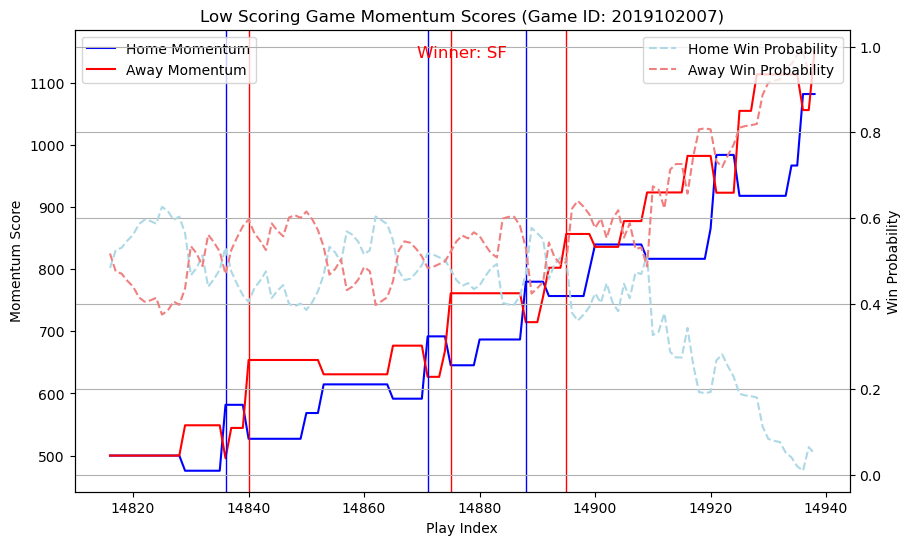

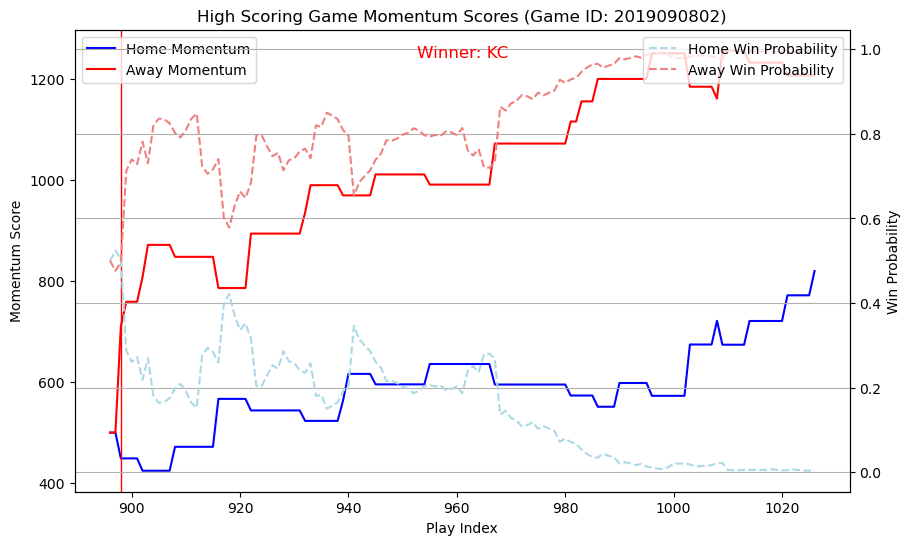

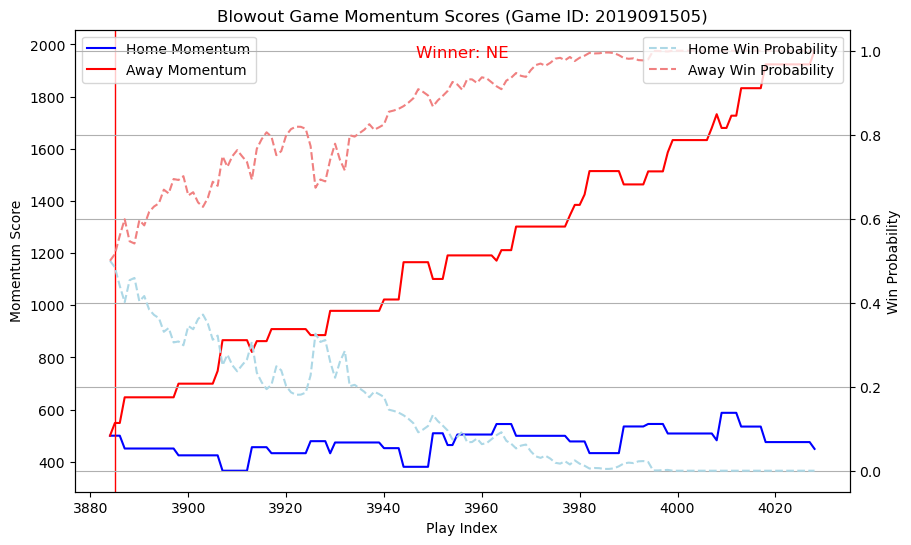

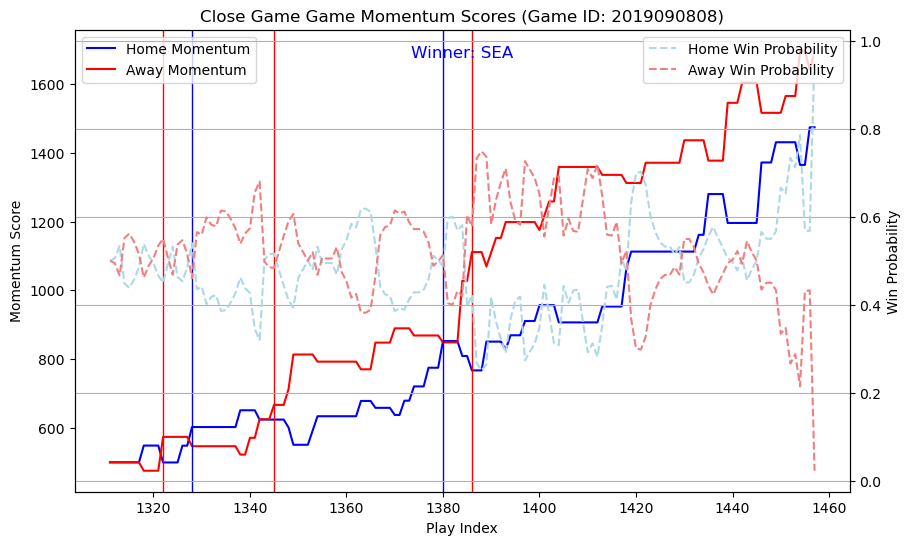

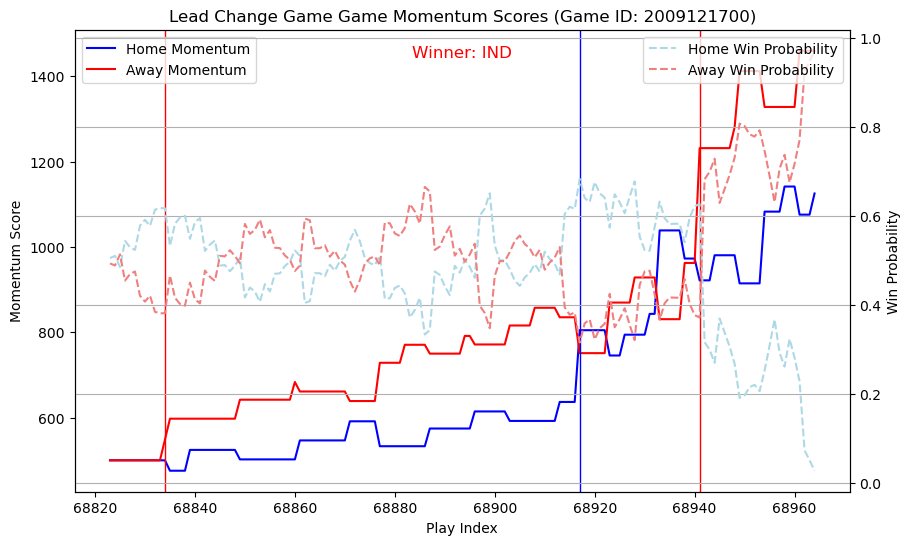

In [47]:
low_scoring_game_id = 2019102007  
high_scoring_game_id = 2019090802  
blowout_game_id = 2019091505     
close_game_id = 2019090808
lead_change_game_id = 2009121700 

low_scoring_game = dfV5[dfV5['game_id'] == low_scoring_game_id]
high_scoring_game = dfV5[dfV5['game_id'] == high_scoring_game_id]
blowout_game = dfV5[dfV5['game_id'] == blowout_game_id]
close_game = dfV5[dfV5['game_id'] == close_game_id]
lead_change_game = dfV5[dfV5['game_id'] == lead_change_game_id]

def plot_momentum_scores(game_data, game_id, game_type, home_score, away_score, home_team, away_team):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(game_data['Home_Momentum_Score'], label='Home Momentum', color='blue')
    ax1.plot(game_data['Away_Momentum_Score'], label='Away Momentum', color='red')
    
    ax1.set_xlabel('Play Index')
    ax1.set_ylabel('Momentum Score', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()
    ax2.plot(game_data['home_wp'], label='Home Win Probability', color='lightblue', linestyle='--')
    ax2.plot(game_data['away_wp'], label='Away Win Probability', color='lightcoral', linestyle='--')
    
    ax2.set_ylabel('Win Probability', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    if home_score > away_score:
        winner = home_team
        winner_color = 'blue'  
    elif away_score > home_score:
        winner = away_team
        winner_color = 'red'   
    else:
        winner = "Draw"
        winner_color = 'gray'  
    
    plt.title(f'{game_type} Game Momentum Scores (Game ID: {game_id})')
    plt.text(0.5, 0.95, f'Winner: {winner}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color=winner_color)

    momentum_shifts = game_data[game_data['Momentum_Shift_Occurred'] == True].index
    for shift in momentum_shifts:
        holding_team = dfV5.at[shift, 'Momentum_Holding_Team']
        if holding_team == 'Home':
            ax1.axvline(x=shift, color='blue', linestyle='-', linewidth=1) 
        elif holding_team == 'Away':
            ax1.axvline(x=shift, color='red', linestyle='-', linewidth=1) 

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.grid(True)
    plt.show()

final_game_rows = dfV5.groupby('game_id').tail(1)

plot_momentum_scores(low_scoring_game, low_scoring_game_id, 'Low Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == low_scoring_game_id, 'total_away_score'].iloc[0],
                     low_scoring_game['home_team'].iloc[0], low_scoring_game['away_team'].iloc[0])

plot_momentum_scores(high_scoring_game, high_scoring_game_id, 'High Scoring',
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == high_scoring_game_id, 'total_away_score'].iloc[0],
                     high_scoring_game['home_team'].iloc[0], high_scoring_game['away_team'].iloc[0])

plot_momentum_scores(blowout_game, blowout_game_id, 'Blowout',
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == blowout_game_id, 'total_away_score'].iloc[0],
                     blowout_game['home_team'].iloc[0], blowout_game['away_team'].iloc[0])

plot_momentum_scores(close_game, close_game_id, 'Close Game',
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == close_game_id, 'total_away_score'].iloc[0],
                     close_game['home_team'].iloc[0], close_game['away_team'].iloc[0])

plot_momentum_scores(lead_change_game, lead_change_game_id, 'Lead Change Game',
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_home_score'].iloc[0],
                     final_game_rows.loc[final_game_rows['game_id'] == lead_change_game_id, 'total_away_score'].iloc[0],
                     lead_change_game['home_team'].iloc[0], lead_change_game['away_team'].iloc[0])

## Filled in known missing values: home_drive_number, away_drive_number, home_csum_first_downs, away_csum_first_downs, Dynamic_Threshold

In [48]:
columns_to_fill = ['home_drive_number', 'away_drive_number', 'home_csum_first_downs', 
                    'away_csum_first_downs', 'Dynamic_Threshold', 'yards_gained']
dfV5[columns_to_fill] = dfV5[columns_to_fill].fillna(0)
print(dfV5.isna().sum())

game_id                        0
home_team                      0
away_team                      0
posteam                        0
defteam                        0
half_seconds_remaining         0
qtr                            0
down                           0
goal_to_go                     0
play_type                      0
yards_gained                   0
home_timeouts_remaining        0
away_timeouts_remaining        0
total_home_score               0
total_away_score               0
home_wp                        0
away_wp                        0
first_down_penalty             0
close_to_end_of_half           0
close_to_end_of_game           0
home_td                        0
away_td                        0
home_wp_change                 0
away_wp_change                 0
turnover                       0
long_td                        0
home_score_differential        0
away_score_differential        0
lead_change                    0
first_down                     0
home_csum_

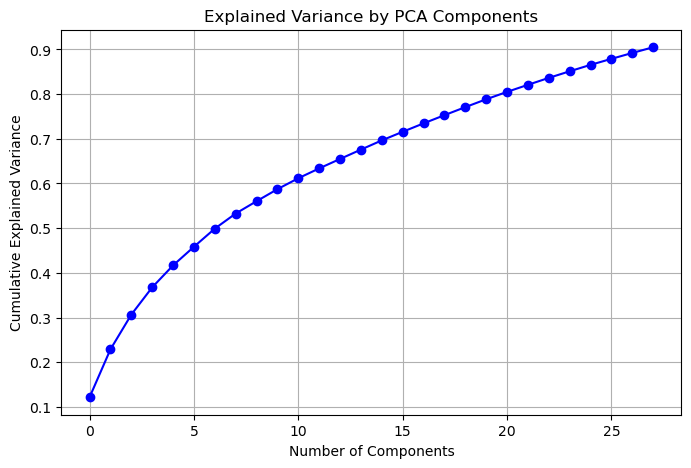

Number of components chosen: 28


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


features = dfV5.drop(['Momentum_Shift_Occurred'], axis=1)  
numeric_df = dfV5.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA(n_components=0.90)
principal_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

print(f"Number of components chosen: {pca.n_components_}")

In [54]:
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_df['Momentum_Shift_Occurred'] = dfV5['Momentum_Shift_Occurred'].values
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Momentum_Shift_Occurred
0,-1.687125,-3.707486,0.045545,-0.620607,0.208524,0.593475,0.128099,-0.379656,0.041237,0.229052,1.038857,-0.853974,0.181978,0.525492,-0.084123,0.005281,0.148108,0.183786,0.297275,0.440398,0.339173,-0.143751,0.449989,-0.497835,0.246460,0.032015,-0.907290,-0.102303,False
1,-1.596040,-3.680414,-0.237344,-0.412702,0.209967,0.709786,-0.350405,-0.278730,0.118131,0.013840,0.981145,-0.841258,0.107184,0.513668,-0.013750,0.100436,0.094613,0.148719,0.380350,0.176861,0.312769,-0.208930,0.532566,-0.456917,0.157338,-0.037669,-0.501972,-0.088099,False
2,-1.374388,-3.375904,-1.838960,0.021445,0.172945,0.657002,-0.478668,-0.791455,0.134279,-0.078478,0.946372,-0.941009,-0.156751,0.508675,-0.076449,0.059406,0.294812,0.555528,0.971864,-0.322627,0.385344,-0.224314,0.631167,-0.265187,0.217120,-0.150669,0.236707,-0.014564,True
3,-0.683445,-2.979521,-4.448617,1.933816,0.946206,0.582002,-2.015595,0.306071,-0.166008,-0.360781,0.391384,-1.127535,0.092049,0.363781,-0.537821,-0.391356,-0.816016,2.615489,-0.643394,-0.253621,-0.035641,-0.262287,0.295065,-0.201232,0.052978,-0.344152,1.038122,0.565879,False
4,-1.271324,-3.414531,0.822139,-0.401040,-0.336904,-0.020445,1.295173,0.901652,0.491352,-3.526588,-1.655021,-0.891940,-0.055220,0.570565,-1.138354,-3.238650,3.234017,1.049773,1.007009,0.693721,0.450876,0.264625,-0.151307,-0.674667,1.000900,0.030768,-1.428757,0.083162,False


In [52]:
categories = {
    "score_game_multipliers": {
        "tied_or_1_score": (dfV5['posteam'] == dfV5['home_team']) & (dfV5['home_score_differential'] <= 8), 
        "2_score": (dfV5['posteam'] == dfV5['home_team']) & (dfV5['home_score_differential'] >= 9) & (dfV5['home_score_differential'] <= 16),          
        "3_or_more_score": (dfV5['posteam'] == dfV5['home_team']) & (dfV5['home_score_differential'] >= 17) & (dfV5['home_score_differential'] <= 24),  
    },
    "qtr_multipliers": {
        "first_and_fourth": (dfV5['qtr'].isin([1, 4])),  # First and Fourth quarter
        "second_and_third": (dfV5['qtr'].isin([2, 3])),  # Second and Third quarter
    },
    "home_away_multipliers": {
        "home": (dfV5['home_team'] == dfV5['posteam']),  # Home team possession
        "away": (dfV5['home_team'] != dfV5['posteam']),  # Away team possession
    },
    "boost_case_multipliers": {
        "home_and_4th": (dfV5['home_team'] == dfV5['posteam']) & (dfV5['qtr'] == 4),
        "away_and_1st": (dfV5['home_team'] != dfV5['posteam']) & (dfV5['qtr'] == 1),
    },
}

wp_change_analysis = {}

def get_wp_change_col(row):
    return row['home_wp_change'] if row['posteam'] == row['home_team'] else row['away_wp_change']

for category, conditions in categories.items():
    wp_change_analysis[category] = {}
    
    for condition_name, condition_mask in conditions.items():
        filtered_df = dfV5.loc[condition_mask]
   
        wp_changes = filtered_df.apply(get_wp_change_col, axis=1)
        
        wp_change_analysis[category][condition_name] = {
            'mean_wp_change': wp_changes.mean(),
            'max_wp_change': wp_changes.max(),
            'count': len(wp_changes),
        }

wp_change_analysis_df = pd.DataFrame([
    {
        'category': category,
        'condition': condition,
        'mean_wp_change': data['mean_wp_change'],
        'max_wp_change': data['max_wp_change'],
        'count': data['count'],
    }
    for category, conditions in wp_change_analysis.items()
    for condition, data in conditions.items()
])

print(wp_change_analysis_df)

                 category         condition  mean_wp_change  max_wp_change  \
0  score_game_multipliers   tied_or_1_score       -0.001288       0.937904   
1  score_game_multipliers           2_score        0.002016       0.274060   
2  score_game_multipliers   3_or_more_score        0.001613       0.221999   
3         qtr_multipliers  first_and_fourth       -0.000587       0.940764   
4         qtr_multipliers  second_and_third       -0.000905       0.353794   
5   home_away_multipliers              home       -0.000741       0.937904   
6   home_away_multipliers              away       -0.000747       0.940764   
7  boost_case_multipliers      home_and_4th        0.001778       0.937904   
8  boost_case_multipliers      away_and_1st       -0.001857       0.661103   

    count  
0  173311  
1   24154  
2   10308  
3  208632  
4  210497  
5  212180  
6  209882  
7   56620  
8   46999  


Score Difference Multiplier:
0.937904-0.274060 = 0.6634844.... 0.274060 - 0.221999 = 0.052061.........0.6634844 + 0.052061 = 0.715545 / 2 = 0.3577727
tied game = 1.6634844, 2 score = 1.3577727, 3 score = 1.274060

qtr multipliers: 
First and Fourth = 1.5522285 ... Mean % difference * Max % difference... Scaled to tenths place and added 1
Second and Third = 1.3201836 ... Mean % difference * Max % difference... Scaled to tenths place and added 1

Home/Away multipliers: 
Home = 1.07949869 ... Mean % difference * Max % difference... Scaled to tenths place and added 1
Away = 1.06027507 ... Mean % difference * Max % difference... Scaled to tenths place and added 1

Boost Case multipliers: 
First and Away = 1.12276683 ... Mean % difference * Max % difference... Scaled to tenths place and added 1
Fourth and Home = 1.16675933 ... Mean % difference * Max % difference... Scaled to tenths place and added 1
